# 2022 Bahrain Grand Prix Analysis

In [1]:
# !jt -t gruvboxl -T -f liberation -tf loraserif -fs 11 -ofs 85 -dfs 10 -tfs 11 -lineh 150 -cursw 3 -cursc r -cellw 100%

In [2]:
# !pip install fastf1
import fastf1 as ff1
from fastf1 import plotting
from fastf1 import utils
from fastf1.core import Laps
from matplotlib import pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib import cm
import numpy as np
import pandas as pd
from timple.timedelta import strftimedelta
plotting.setup_mpl()
ff1.Cache.enable_cache('C:/Users/EDGAR/Jupyter Files/FastF1Cache')

## Qualifying Analysis

In [3]:
quali=ff1.get_session(2022,'Bahrain','Q')
laps=quali.load_laps(with_telemetry=True)

utils          INFO 	Note: NumExpr detected 16 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
utils          INFO 	NumExpr defaulting to 8 threads.
C:\Users\EDGAR\anaconda3\lib\site-packages\fastf1\core.py:1127: FutureWarning: `Session.load_laps` is deprecated and will beremoved in a future version.
Use `Session.load` instead.
  warnings.warn("`Session.load_laps` is deprecated and will be"
core           INFO 	Loading data for Bahrain Grand Prix - Qualifying [v2.2.7]
api            INFO 	Updating cache for driver_info...
api            INFO 	Fetching driver list...
api            INFO 	Cache updated!
api            INFO 	Updating cache for timing_data...
api            INFO 	Fetching timing data...
api            INFO 	Parsing timing data...
api            INFO 	Cache updated!
api            INFO 	Updating cache for timing_app_data...
api            INFO 	Fetching timing app data...
api            INFO 	Cache updated!
core           INFO 	Processing timing data.

### Q3 Fastest Lap & Driver

In [4]:
q3fl=laps.pick_fastest()[['LapTime','Driver','Team']]
q3fl

LapTime    0 days 00:01:30.558000
Driver                        LEC
Team                      Ferrari
dtype: object

### Minisector Comparison between Top 4 Qualifying Drivers

#### Who are the top 4 qualifying drivers?

In [5]:
quali.results[:4]
#Leclerc, Verstappen, Sainz, Perez

,DriverNumber,BroadcastName,Abbreviation,TeamName,TeamColor,FirstName,LastName,FullName,Position,GridPosition,Q1,Q2,Q3,Time,Status,Points
16,16,C LECLERC,LEC,Ferrari,ed1c24,Charles,Leclerc,Charles Leclerc,1.0,0.0,0 days 00:01:31.471000,0 days 00:01:30.932000,0 days 00:01:30.558000,NaT,,0.0
1,1,M VERSTAPPEN,VER,Red Bull Racing,1e5bc6,Max,Verstappen,Max Verstappen,2.0,0.0,0 days 00:01:31.785000,0 days 00:01:30.757000,0 days 00:01:30.681000,NaT,,0.0
55,55,C SAINZ,SAI,Ferrari,ed1c24,Carlos,Sainz,Carlos Sainz,3.0,0.0,0 days 00:01:31.567000,0 days 00:01:30.787000,0 days 00:01:30.687000,NaT,,0.0
11,11,S PEREZ,PER,Red Bull Racing,1e5bc6,Sergio,Perez,Sergio Perez,4.0,0.0,0 days 00:01:32.311000,0 days 00:01:31.008000,0 days 00:01:30.921000,NaT,,0.0


In [6]:
#Getting the laps from all 4 drivers
llec=laps.pick_driver('LEC')
lver=laps.pick_driver('VER')
lsai=laps.pick_driver('SAI')
lper=laps.pick_driver('PER')
#Getting telemetry data from drivers
flec=llec.pick_fastest().get_telemetry().add_distance()
fver=lver.pick_fastest().get_telemetry().add_distance()
fsai=lsai.pick_fastest().get_telemetry().add_distance()
fper=lper.pick_fastest().get_telemetry().add_distance()
#Creating Driver column
flec['Driver']='LEC'
fver['Driver']='VER'
fsai['Driver']='SAI'
fper['Driver']='PER'
#Getting everything in one dataframe
t1=flec.append(fver)
t2=t1.append(fsai)
telemetry=t2.append(fper)

In [7]:
telemetry.info()

<class 'fastf1.core.Telemetry'>
Int64Index: 2780 entries, 2 to 708
Data columns (total 19 columns):
 #   Column                 Non-Null Count  Dtype          
---  ------                 --------------  -----          
 0   Date                   2780 non-null   datetime64[ns] 
 1   SessionTime            2780 non-null   timedelta64[ns]
 2   DriverAhead            2780 non-null   object         
 3   DistanceToDriverAhead  2780 non-null   float64        
 4   Time                   2780 non-null   timedelta64[ns]
 5   RPM                    2780 non-null   int64          
 6   Speed                  2780 non-null   int64          
 7   nGear                  2780 non-null   int64          
 8   Throttle               2780 non-null   int64          
 9   Brake                  2780 non-null   bool           
 10  DRS                    2780 non-null   int64          
 11  Source                 2780 non-null   object         
 12  RelativeDistance       2780 non-null   float64        


In [8]:
#Creating the minisectors (doing 30 - 10 per sector)
nmini=30
#Grabbing circuit distance
cdist=max(telemetry['Distance'])
#Dividing circuit distance by number of minisectors to have our minisector distance
minilen=cdist/nmini
#Calculating distances at which the next minisector begins
minis=[0]
for b in range(0,(nmini-1)):
    minis.append(minilen*(b+1))
#Assigning every row in the dataset to a minisector, so we always know which minisector the cars were located in.
telemetry['Minisector']=telemetry['Distance'].apply(
    lambda dist:(
        int((dist // minilen)+1)))

In [9]:
#Finding the fastest driver per minisector so we can color it in the minisector map
avgspeed=telemetry.groupby(['Minisector','Driver'])['Speed'].mean().reset_index()
fastest = avgspeed.loc[avgspeed.groupby(['Minisector'])['Speed'].idxmax()]
fastest = fastest[['Minisector', 'Driver']].rename(columns={'Driver': 'Fastest_Driver'})

In [10]:
fastest['Fastest_Driver'].unique()
#4 drivers had a fastest minisector
fastest['Fastest_Driver']=='LEC'

3      False
5      False
9      False
12      True
17     False
22     False
26     False
28      True
32      True
38     False
40      True
46     False
49     False
52      True
56      True
62     False
66     False
70     False
73     False
79     False
80      True
87     False
89     False
95     False
99     False
103    False
104     True
111    False
115    False
119    False
Name: Fastest_Driver, dtype: bool

In [11]:
# Fastest driver per minisector + telemetry
telemetry = telemetry.merge(fastest, on=['Minisector'])

# Ordering by distance
telemetry = telemetry.sort_values(by=['Distance'])

# Converting driver name to integer
telemetry.loc[telemetry['Fastest_Driver'] == 'LEC', 'Fastest_Driver_int'] = 1
telemetry.loc[telemetry['Fastest_Driver'] == 'VER', 'Fastest_Driver_int'] = 2
telemetry.loc[telemetry['Fastest_Driver'] == 'SAI', 'Fastest_Driver_int'] = 3
telemetry.loc[telemetry['Fastest_Driver'] == 'PER', 'Fastest_Driver_int'] = 4

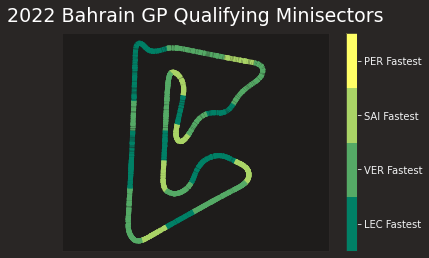

In [43]:
# Finally, plotting.
x = np.array(telemetry['X'].values)
y = np.array(telemetry['Y'].values)

points = np.array([x, y]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)
fastest_driver_array = telemetry['Fastest_Driver_int'].to_numpy().astype(float)

cmap = cm.get_cmap('summer', 4)
lc_comp = LineCollection(segments, norm=plt.Normalize(1, cmap.N+1), cmap=cmap)
lc_comp.set_array(fastest_driver_array)
lc_comp.set_linewidth(5)

# plt.rcParams['figure.figsize'] = [18, 10]

plt.gca().add_collection(lc_comp)
plt.axis('equal')
plt.tick_params(labelleft=False, left=False, labelbottom=False, bottom=False)
plt.title('2022 Bahrain GP Qualifying Minisectors',color='white')
cbar = plt.colorbar(mappable=lc_comp, boundaries=np.arange(1,6))
cbar.set_ticks(np.arange(1.5, 9.5))
cbar.set_ticklabels(['LEC Fastest', 'VER Fastest','SAI Fastest','PER Fastest'])

plt.savefig(f"2022 Bahrain GP Qualifying Minisectors.png", dpi=300)

plt.show()

### Qualifying Time Difference Graph

In [13]:
#Getting every driver
drv = pd.unique(quali.laps['Driver'])
laps['Driver'].isna().sum()

0

In [14]:
#Sorting laps by LapTime
fl_list= list()
for d in drv:
    drv_fl = quali.laps.pick_driver(d).pick_fastest()
    fl_list.append(drv_fl)
fl = Laps(fl_list).sort_values(by='LapTime').reset_index(drop=True)

In [15]:
#getting the fastest lap
pole=fl.pick_fastest()
fl['LapTimeDiff']=fl['LapTime']-pole['LapTime']
print(fl[['Driver', 'LapTime', 'LapTimeDiff']])

   Driver                LapTime            LapTimeDiff
0     LEC 0 days 00:01:30.558000        0 days 00:00:00
1     VER 0 days 00:01:30.681000 0 days 00:00:00.123000
2     SAI 0 days 00:01:30.687000 0 days 00:00:00.129000
3     PER 0 days 00:01:30.921000 0 days 00:00:00.363000
4     HAM 0 days 00:01:31.238000 0 days 00:00:00.680000
5     BOT 0 days 00:01:31.560000 0 days 00:00:01.002000
6     OCO 0 days 00:01:31.782000 0 days 00:00:01.224000
7     MAG 0 days 00:01:31.808000 0 days 00:00:01.250000
8     MSC 0 days 00:01:31.998000 0 days 00:00:01.440000
9     NOR 0 days 00:01:32.008000 0 days 00:00:01.450000
10    ALO 0 days 00:01:32.195000 0 days 00:00:01.637000
11    RUS 0 days 00:01:32.216000 0 days 00:00:01.658000
12    GAS 0 days 00:01:32.338000 0 days 00:00:01.780000
13    ALB 0 days 00:01:32.664000 0 days 00:00:02.106000
14    TSU 0 days 00:01:32.750000 0 days 00:00:02.192000
15    HUL 0 days 00:01:32.777000 0 days 00:00:02.219000
16    RIC 0 days 00:01:32.945000 0 days 00:00:02

In [16]:
#creating a list of team colors for the graph
tcol = list()
for index, lap in fl.iterlaps():
    color = ff1.plotting.team_color(lap['Team'])
    tcol.append(color)

C:\Users\EDGAR\anaconda3\lib\site-packages\fastf1\core.py:931: FutureWarning: The property `Session.weekend` has been renamed to `Session.event`.
 The old property will be removed ina future version.
  warnings.warn("The property `Session.weekend` has been renamed to "
C:\Users\EDGAR\anaconda3\lib\site-packages\fastf1\events.py:650: FutureWarning: The `Weekend.name` property is deprecated and will beremoved in a future version.
Use `Event['EventName']` or `Event.EventName` instead.
  warnings.warn(


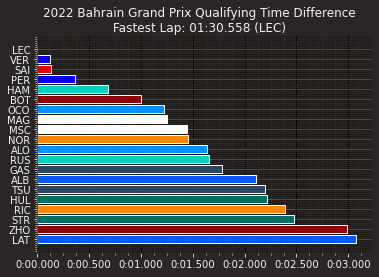

In [17]:
#Finally, plotting and titling

fig, ax = plt.subplots()
ax.barh(fl.index, fl['LapTimeDiff'],color=tcol, edgecolor='white')
ax.set_yticks(fl.index)
ax.set_yticklabels(fl['Driver'])
ax.invert_yaxis()
ax.set_axisbelow(True)
ax.xaxis.grid(True, which='major', linestyle='-.', color='black', zorder=-1000)
lapstr = strftimedelta(pole['LapTime'], '%m:%s.%ms')
plt.suptitle(f"{quali.weekend.year} {quali.weekend.name} Qualifying Time Difference\n"
             f"Fastest Lap: {lapstr} ({pole['Driver']})")
plt.savefig(f"2022 Bahrain GP Qualifying Time Difference.png", dpi=300)

plt.show()

### Qualifying Pace Over Distance Analysis - Top 4 Drivers

In [18]:
#Getting the laps from all 4 drivers
llec=laps.pick_driver('LEC')
lver=laps.pick_driver('VER')
lsai=laps.pick_driver('SAI')
lper=laps.pick_driver('PER')
#Getting telemetry data from drivers
flec=llec.pick_fastest().get_telemetry().add_distance()
fver=lver.pick_fastest().get_telemetry().add_distance()
fsai=lsai.pick_fastest().get_telemetry().add_distance()
fper=lper.pick_fastest().get_telemetry().add_distance()
#Creating Driver column
flec['Driver']='LEC'
fver['Driver']='VER'
fsai['Driver']='SAI'
fper['Driver']='PER'
#Getting everything in one dataframe
t1=flec.append(fver)
t2=t1.append(fsai)
telemetry=t2.append(fper)

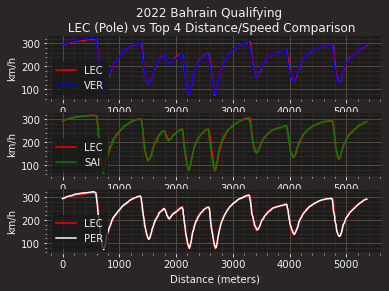

In [19]:
# plt.rcParams['figure.figsize'] = [10, 6]
fig, ax = plt.subplots(3)
fig.suptitle("2022 Bahrain Qualifying\n LEC (Pole) vs Top 4 Distance/Speed Comparison")
# plt.subplots_adjust(wspace=0.4,hspace=0.4)

ax[0].plot(flec['Distance'], flec['Speed'], label='LEC',color='red')
ax[0].plot(fver['Distance'], fver['Speed'], label='VER',color='blue')
ax[0].set(ylabel='km/h', xlabel='Distance (meters)')
ax[0].legend(loc="lower left")

ax[1].plot(flec['Distance'], flec['Speed'], label='LEC',color='red')
ax[1].plot(fsai['Distance'], fsai['Speed'], label='SAI',color='green')
ax[1].set(ylabel='km/h', xlabel='Distance (meters)')
ax[1].legend(loc="lower left")

ax[2].plot(flec['Distance'], flec['Speed'], label='LEC',color='red')
ax[2].plot(fper['Distance'], fper['Speed'], label='PER',color='white')
ax[2].set(ylabel='km/h', xlabel='Distance (meters)')
ax[2].legend(loc="lower left")

plt.savefig(f"2022 Bahrain GP Qualifying Distance-Speed Comparison.png",dpi=1000)
plt.show()

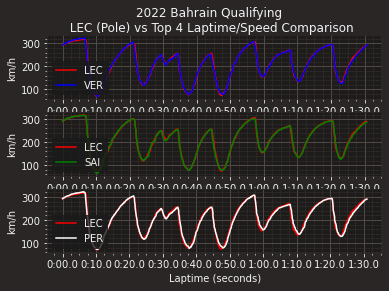

In [20]:
fig, ax = plt.subplots(3)
fig.suptitle("2022 Bahrain Qualifying\n LEC (Pole) vs Top 4 Laptime/Speed Comparison")
# plt.subplots_adjust(wspace=0.4,hspace=0.4)
ax[0].plot(flec['Time'], flec['Speed'], label='LEC', color='red')
ax[0].plot(fver['Time'], fver['Speed'], label='VER', color='blue')
ax[0].set(ylabel='km/h', xlabel='Laptime (seconds)')
ax[0].legend(loc="lower left")

ax[1].plot(flec['Time'], flec['Speed'], label='LEC', color='red')
ax[1].plot(fsai['Time'], fsai['Speed'], label='SAI', color='green')
ax[1].set(ylabel='km/h', xlabel='Laptime (seconds)')
ax[1].legend(loc="lower left")

ax[2].plot(flec['Time'], flec['Speed'], label='LEC', color='red')
ax[2].plot(fper['Time'], fper['Speed'], label='PER', color='white')
ax[2].set(ylabel='km/h', xlabel='Laptime (seconds)')
ax[2].legend(loc="lower left")

plt.savefig(f"2022 Bahrain GP Qualifying Laptime-Speed Comparison.png",dpi=1000)
plt.show()

### Comparing Teammates

In [21]:
#We're comparing Zhou with Bottas and Schumacher with Magnussen's best qualifying times.

In [22]:
#Creating lap dataframes and sorting them by LapTime.

zhou=pd.DataFrame(quali.laps.pick_driver('ZHO').pick_fastest()).T
bot=pd.DataFrame(quali.laps.pick_driver('BOT').pick_fastest()).T
merge1=pd.merge(zhou,bot,how='outer')
fl1 = Laps(merge1).sort_values(by='LapTime').reset_index(drop=True)
fl1.dropna(axis=1)

schu=pd.DataFrame(quali.laps.pick_driver('MSC').pick_fastest()).T
magn=pd.DataFrame(quali.laps.pick_driver('MAG').pick_fastest()).T
merge2=pd.merge(schu,magn,how='outer')
fl2=Laps(merge2).sort_values(by='LapTime').reset_index(drop=True)
fl2.dropna(axis=1)

ricc=pd.DataFrame(quali.laps.pick_driver('RIC').pick_fastest()).T
norr=pd.DataFrame(quali.laps.pick_driver('NOR').pick_fastest()).T
merge3=pd.merge(ricc,norr,how='outer')
fl3=Laps(merge3).sort_values(by='LapTime').reset_index(drop=True)
fl3.dropna(axis=1)

,Time,DriverNumber,LapTime,LapNumber,Stint,Sector1Time,Sector2Time,Sector3Time,Sector1SessionTime,Sector2SessionTime,...,IsPersonalBest,Compound,TyreLife,FreshTyre,LapStartTime,Team,Driver,TrackStatus,IsAccurate,LapStartDate
0,0 days 00:54:57.610000,4,0 days 00:01:32.008000,13.0,4.0,0 days 00:00:29.544000,0 days 00:00:39.355000,0 days 00:00:23.109000,0 days 00:53:55.146000,0 days 00:54:34.501000,...,True,SOFT,3.0,True,0 days 00:53:25.602000,McLaren,NOR,1,True,2022-03-19 15:38:26.531
1,0 days 00:32:41.097000,3,0 days 00:01:32.945000,8.0,2.0,0 days 00:00:29.763000,0 days 00:00:39.862000,0 days 00:00:23.320000,0 days 00:31:37.915000,0 days 00:32:17.777000,...,True,SOFT,3.0,True,0 days 00:31:08.152000,McLaren,RIC,1,True,2022-03-19 15:16:09.081


In [23]:
best1=fl1.pick_fastest()
fl1['LapTimeDiff']=fl1['LapTime']-best1['LapTime']
print(fl1[['Driver', 'LapTime', 'LapTimeDiff']])

best2=fl2.pick_fastest()
fl2['LapTimeDiff']=fl2['LapTime']-best2['LapTime']
print(fl2[['Driver', 'LapTime', 'LapTimeDiff']])

best3=fl3.pick_fastest()
fl3['LapTimeDiff']=fl3['LapTime']-best3['LapTime']
print(fl3[['Driver', 'LapTime', 'LapTimeDiff']])

  Driver                LapTime            LapTimeDiff
0    BOT 0 days 00:01:31.560000        0 days 00:00:00
1    ZHO 0 days 00:01:33.543000 0 days 00:00:01.983000
  Driver                LapTime            LapTimeDiff
0    MAG 0 days 00:01:31.808000        0 days 00:00:00
1    MSC 0 days 00:01:31.998000 0 days 00:00:00.190000
  Driver                LapTime            LapTimeDiff
0    NOR 0 days 00:01:32.008000        0 days 00:00:00
1    RIC 0 days 00:01:32.945000 0 days 00:00:00.937000


In [24]:
tcol1 = list()
for index, lap in fl1.iterlaps():
    color = ff1.plotting.team_color(lap['Team'])
    tcol1.append(color)

tcol2 = list()
for index, lap in fl2.iterlaps():
    color = ff1.plotting.team_color(lap['Team'])
    tcol2.append(color)
    
tcol3 = list()
for index, lap in fl3.iterlaps():
    color = ff1.plotting.team_color(lap['Team'])
    tcol3.append(color)

C:\Users\EDGAR\anaconda3\lib\site-packages\fastf1\core.py:931: FutureWarning: The property `Session.weekend` has been renamed to `Session.event`.
 The old property will be removed ina future version.
  warnings.warn("The property `Session.weekend` has been renamed to "
C:\Users\EDGAR\anaconda3\lib\site-packages\fastf1\events.py:650: FutureWarning: The `Weekend.name` property is deprecated and will beremoved in a future version.
Use `Event['EventName']` or `Event.EventName` instead.
  warnings.warn(


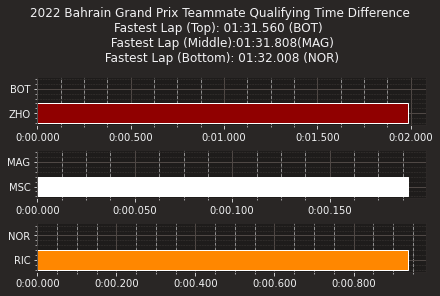

In [25]:

fig, ax = plt.subplots(3,constrained_layout=True)
ax[0].barh(fl1.index, fl1['LapTimeDiff'],color=tcol1, edgecolor='white')
ax[0].set_yticks(fl1.index)
ax[0].set_yticklabels(fl1['Driver'])
ax[0].invert_yaxis()
ax[0].set_axisbelow(True)
ax[0].xaxis.grid(True, which='minor', linestyle='-.', color='white', zorder=-1000)
lapstr1 = strftimedelta(best1['LapTime'], '%m:%s.%ms')

ax[1].barh(fl2.index, fl2['LapTimeDiff'],color=tcol2, edgecolor='white')
ax[1].set_yticks(fl2.index)
ax[1].set_yticklabels(fl2['Driver'])
ax[1].invert_yaxis()
ax[1].set_axisbelow(True)
ax[1].xaxis.grid(True, which='minor', linestyle='-.', color='white', zorder=-1000)
lapstr2 = strftimedelta(best2['LapTime'], '%m:%s.%ms')

ax[2].barh(fl3.index, fl3['LapTimeDiff'],color=tcol3, edgecolor='white')
ax[2].set_yticks(fl3.index)
ax[2].set_yticklabels(fl3['Driver'])
ax[2].invert_yaxis()
ax[2].set_axisbelow(True)
ax[2].xaxis.grid(True, which='minor', linestyle='-.', color='white', zorder=-1000)
lapstr3 = strftimedelta(best3['LapTime'], '%m:%s.%ms')
plt.suptitle(f"{quali.weekend.year} {quali.weekend.name} Teammate Qualifying Time Difference\n"
             f"Fastest Lap (Top): {lapstr1} ({best1['Driver']}) \n Fastest Lap (Middle):{lapstr2}({best2['Driver']})\n Fastest Lap (Bottom): {lapstr3} ({best3['Driver']})")


plt.savefig(f"{quali.weekend.year} {quali.weekend.name} Teammate Time Difference.png", dpi=300)

plt.show()

## Race Analysis

### Fastest Minisectors in the race

In [26]:
year=2022
circuit='Bahrain Grand Prix'

race=ff1.get_session(2022,'Bahrain','R')
lapsr=race.load_laps(with_telemetry=True)

C:\Users\EDGAR\anaconda3\lib\site-packages\fastf1\core.py:1127: FutureWarning: `Session.load_laps` is deprecated and will beremoved in a future version.
Use `Session.load` instead.
  warnings.warn("`Session.load_laps` is deprecated and will be"
core           INFO 	Loading data for Bahrain Grand Prix - Race [v2.2.7]
api            INFO 	Updating cache for driver_info...
api            INFO 	Fetching driver list...
api            INFO 	Cache updated!
api            INFO 	Updating cache for timing_data...
api            INFO 	Fetching timing data...
api            INFO 	Parsing timing data...
api            INFO 	Cache updated!
api            INFO 	Updating cache for timing_app_data...
api            INFO 	Fetching timing app data...
api            INFO 	Cache updated!
core           INFO 	Processing timing data...
api            INFO 	Updating cache for session_status_data...
api            INFO 	Fetching session status data...
api            INFO 	Cache updated!
api            INFO 	Up

In [27]:
race.results[:4]

,DriverNumber,BroadcastName,Abbreviation,TeamName,TeamColor,FirstName,LastName,FullName,Position,GridPosition,Q1,Q2,Q3,Time,Status,Points
16,16,C LECLERC,LEC,Ferrari,ed1c24,Charles,Leclerc,Charles Leclerc,1.0,1.0,NaT,NaT,NaT,0 days 01:37:33.584000,Finished,26.0
55,55,C SAINZ,SAI,Ferrari,ed1c24,Carlos,Sainz,Carlos Sainz,2.0,3.0,NaT,NaT,NaT,0 days 01:37:39.182000,Finished,18.0
44,44,L HAMILTON,HAM,Mercedes,6cd3bf,Lewis,Hamilton,Lewis Hamilton,3.0,5.0,NaT,NaT,NaT,0 days 01:37:43.259000,Finished,15.0
63,63,G RUSSELL,RUS,Mercedes,6cd3bf,George,Russell,George Russell,4.0,9.0,NaT,NaT,NaT,0 days 01:37:44.795000,Finished,12.0


In [28]:
#Getting the laps from all 4 drivers
llec=laps.pick_driver('LEC')
lsai=laps.pick_driver('SAI')
lham=laps.pick_driver('HAM')
lrus=laps.pick_driver('RUS')
#Getting telemetry data from drivers
flec=llec.pick_fastest().get_telemetry().add_distance()
fham=lham.pick_fastest().get_telemetry().add_distance()
fsai=lsai.pick_fastest().get_telemetry().add_distance()
frus=lrus.pick_fastest().get_telemetry().add_distance()
#Creating Driver column
flec['Driver']='LEC'
fsai['Driver']='SAI'
fham['Driver']='HAM'
frus['Driver']='RUS'
#Getting everything in one dataframe
t1=flec.append(fsai)
t2=t1.append(fham)
telemetry=t2.append(frus)

In [29]:
#Creating the minisectors (doing 30 - 10 per sector)
nmini=30
#Grabbing circuit distance
cdist=max(telemetry['Distance'])
#Dividing circuit distance by number of minisectors to have our minisector distance
minilen=cdist/nmini
#Calculating distances at which the next minisector begins
minis=[0]
for b in range(0,(nmini-1)):
    minis.append(minilen*(b+1))
#Assigning every row in the dataset to a minisector, so we always know which minisector the cars were located in.
telemetry['Minisector']=telemetry['Distance'].apply(
    lambda dist:(
        int((dist // minilen)+1)))

In [30]:
#Finding the fastest driver per minisector so we can color it in the minisector map
avgspeed=telemetry.groupby(['Minisector','Driver'])['Speed'].mean().reset_index()
fastest = avgspeed.loc[avgspeed.groupby(['Minisector'])['Speed'].idxmax()]
fastest = fastest[['Minisector', 'Driver']].rename(columns={'Driver': 'Fastest_Driver'})

In [31]:
fastest['Fastest_Driver'].unique()
#4 drivers had a fastest minisector
fastest['Fastest_Driver']=='LEC'

1       True
7      False
9       True
13      True
17      True
23     False
27     False
28     False
35     False
39     False
41      True
47     False
48     False
53      True
56     False
63     False
67     False
69      True
72     False
79     False
81      True
85      True
88     False
95     False
99     False
101     True
104    False
111    False
115    False
117     True
Name: Fastest_Driver, dtype: bool

In [32]:
# Fastest driver per minisector + telemetry
telemetry = telemetry.merge(fastest, on=['Minisector'])

# Ordering by distance
telemetry = telemetry.sort_values(by=['Distance'])

# Converting driver name to integer
telemetry.loc[telemetry['Fastest_Driver'] == 'LEC', 'Fastest_Driver_int'] = 1
telemetry.loc[telemetry['Fastest_Driver'] == 'SAI', 'Fastest_Driver_int'] = 2
telemetry.loc[telemetry['Fastest_Driver'] == 'HAM', 'Fastest_Driver_int'] = 3
telemetry.loc[telemetry['Fastest_Driver'] == 'RUS', 'Fastest_Driver_int'] = 4

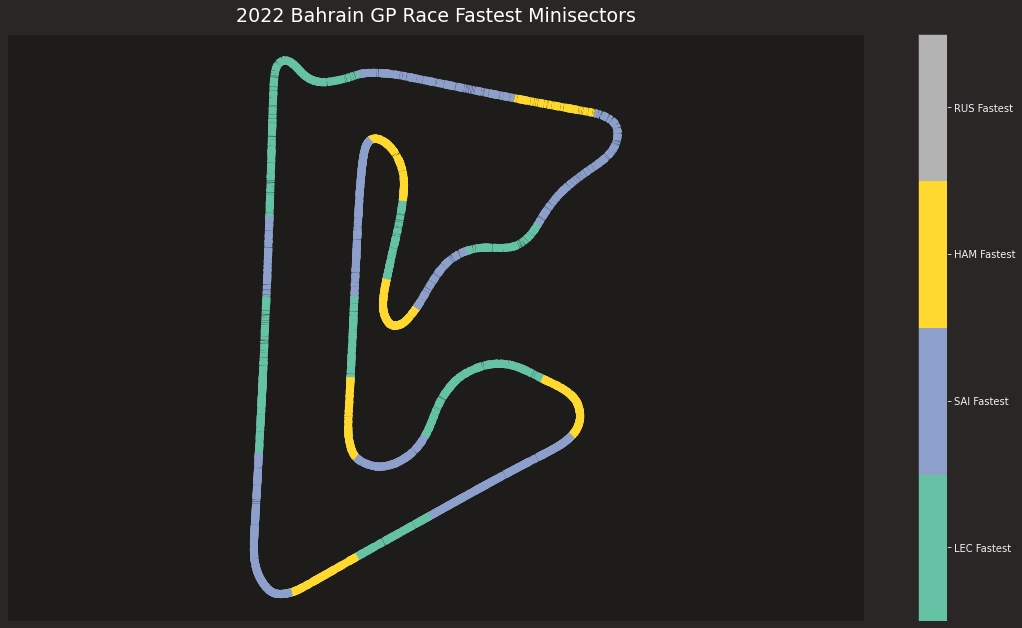

In [33]:
# Finally, plotting.
x = np.array(telemetry['X'].values)
y = np.array(telemetry['Y'].values)

points = np.array([x, y]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)
fastest_driver_array = telemetry['Fastest_Driver_int'].to_numpy().astype(float)

cmap = cm.get_cmap('Set2', 4)
lc_comp = LineCollection(segments, norm=plt.Normalize(1, cmap.N+1), cmap=cmap)
lc_comp.set_array(fastest_driver_array)
lc_comp.set_linewidth(8)


plt.gca().add_collection(lc_comp)
plt.gcf().set_size_inches(19.2,10.8)
plt.axis('equal')
plt.tick_params(labelleft=False, left=False, labelbottom=False, bottom=False)
plt.title('2022 Bahrain GP Race Fastest Minisectors',color='white')
cbar = plt.colorbar(mappable=lc_comp, boundaries=np.arange(1,6))
cbar.set_ticks(np.arange(1.5, 5.5))
cbar.set_ticklabels(['LEC Fastest', 'SAI Fastest','HAM Fastest','RUS Fastest'])

plt.savefig(f"2022 Bahrain GP Race Minisectors.jpeg", dpi=100)

plt.show()

### Race Pace Comparison - Leclerc vs. Verstappen

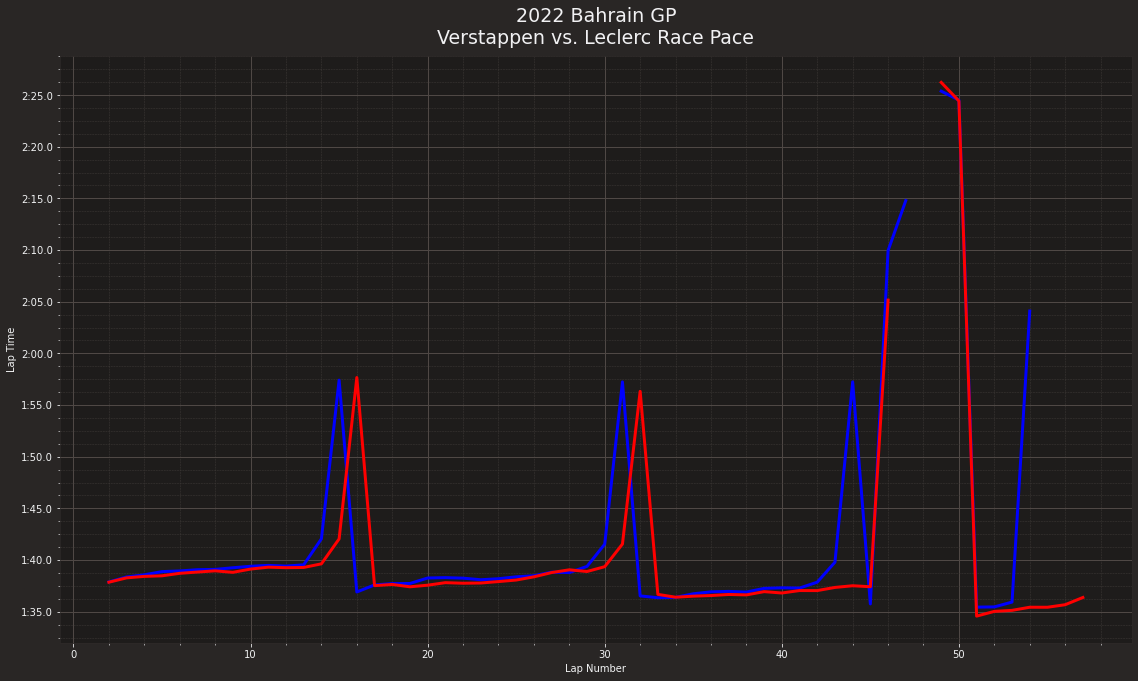

In [34]:
ver = lapsr.pick_driver('VER')
lec = lapsr.pick_driver('LEC')
fig, ax = plt.subplots()
plt.gcf().set_size_inches(19.2,10.8)
ax.plot(ver['LapNumber'], ver['LapTime'], color='blue',linewidth=3)
ax.plot(lec['LapNumber'], lec['LapTime'], color='red',linewidth=3)
ax.set_title("2022 Bahrain GP\n Verstappen vs. Leclerc Race Pace ")
ax.set_xlabel("Lap Number")
ax.set_ylabel("Lap Time")
plt.savefig(f"2022 Bahrain Grand Prix Verstappen vs Leclerc Race Pace Comparison.png",dpi=100)
plt.show()
#no data for laps 46 and 47 for Leclerc, and 48 for Verstappen - hence the lack of values on the graph.

### Race Pace Comparison Between Teammates

In [35]:
race.results

,DriverNumber,BroadcastName,Abbreviation,TeamName,TeamColor,FirstName,LastName,FullName,Position,GridPosition,Q1,Q2,Q3,Time,Status,Points
16,16,C LECLERC,LEC,Ferrari,ed1c24,Charles,Leclerc,Charles Leclerc,1.0,1.0,NaT,NaT,NaT,0 days 01:37:33.584000,Finished,26.0
55,55,C SAINZ,SAI,Ferrari,ed1c24,Carlos,Sainz,Carlos Sainz,2.0,3.0,NaT,NaT,NaT,0 days 01:37:39.182000,Finished,18.0
44,44,L HAMILTON,HAM,Mercedes,6cd3bf,Lewis,Hamilton,Lewis Hamilton,3.0,5.0,NaT,NaT,NaT,0 days 01:37:43.259000,Finished,15.0
63,63,G RUSSELL,RUS,Mercedes,6cd3bf,George,Russell,George Russell,4.0,9.0,NaT,NaT,NaT,0 days 01:37:44.795000,Finished,12.0
20,20,K MAGNUSSEN,MAG,Haas F1 Team,b6babd,Kevin,Magnussen,Kevin Magnussen,5.0,7.0,NaT,NaT,NaT,0 days 01:37:48.338000,Finished,10.0
77,77,V BOTTAS,BOT,Alfa Romeo,b12039,Valtteri,Bottas,Valtteri Bottas,6.0,6.0,NaT,NaT,NaT,0 days 01:37:49.703000,Finished,8.0
31,31,E OCON,OCO,Alpine,2293d1,Esteban,Ocon,Esteban Ocon,7.0,11.0,NaT,NaT,NaT,0 days 01:37:53.007000,Finished,6.0
22,22,Y TSUNODA,TSU,AlphaTauri,4e7c9b,Yuki,Tsunoda,Yuki Tsunoda,8.0,16.0,NaT,NaT,NaT,0 days 01:37:53.970000,Finished,4.0
14,14,F ALONSO,ALO,Alpine,2293d1,Fernando,Alonso,Fernando Alonso,9.0,8.0,NaT,NaT,NaT,0 days 01:37:55.974000,Finished,2.0
24,24,G ZHOU,ZHO,Alfa Romeo,b12039,Guanyu,Zhou,Guanyu Zhou,10.0,15.0,NaT,NaT,NaT,0 days 01:37:56.648000,Finished,1.0


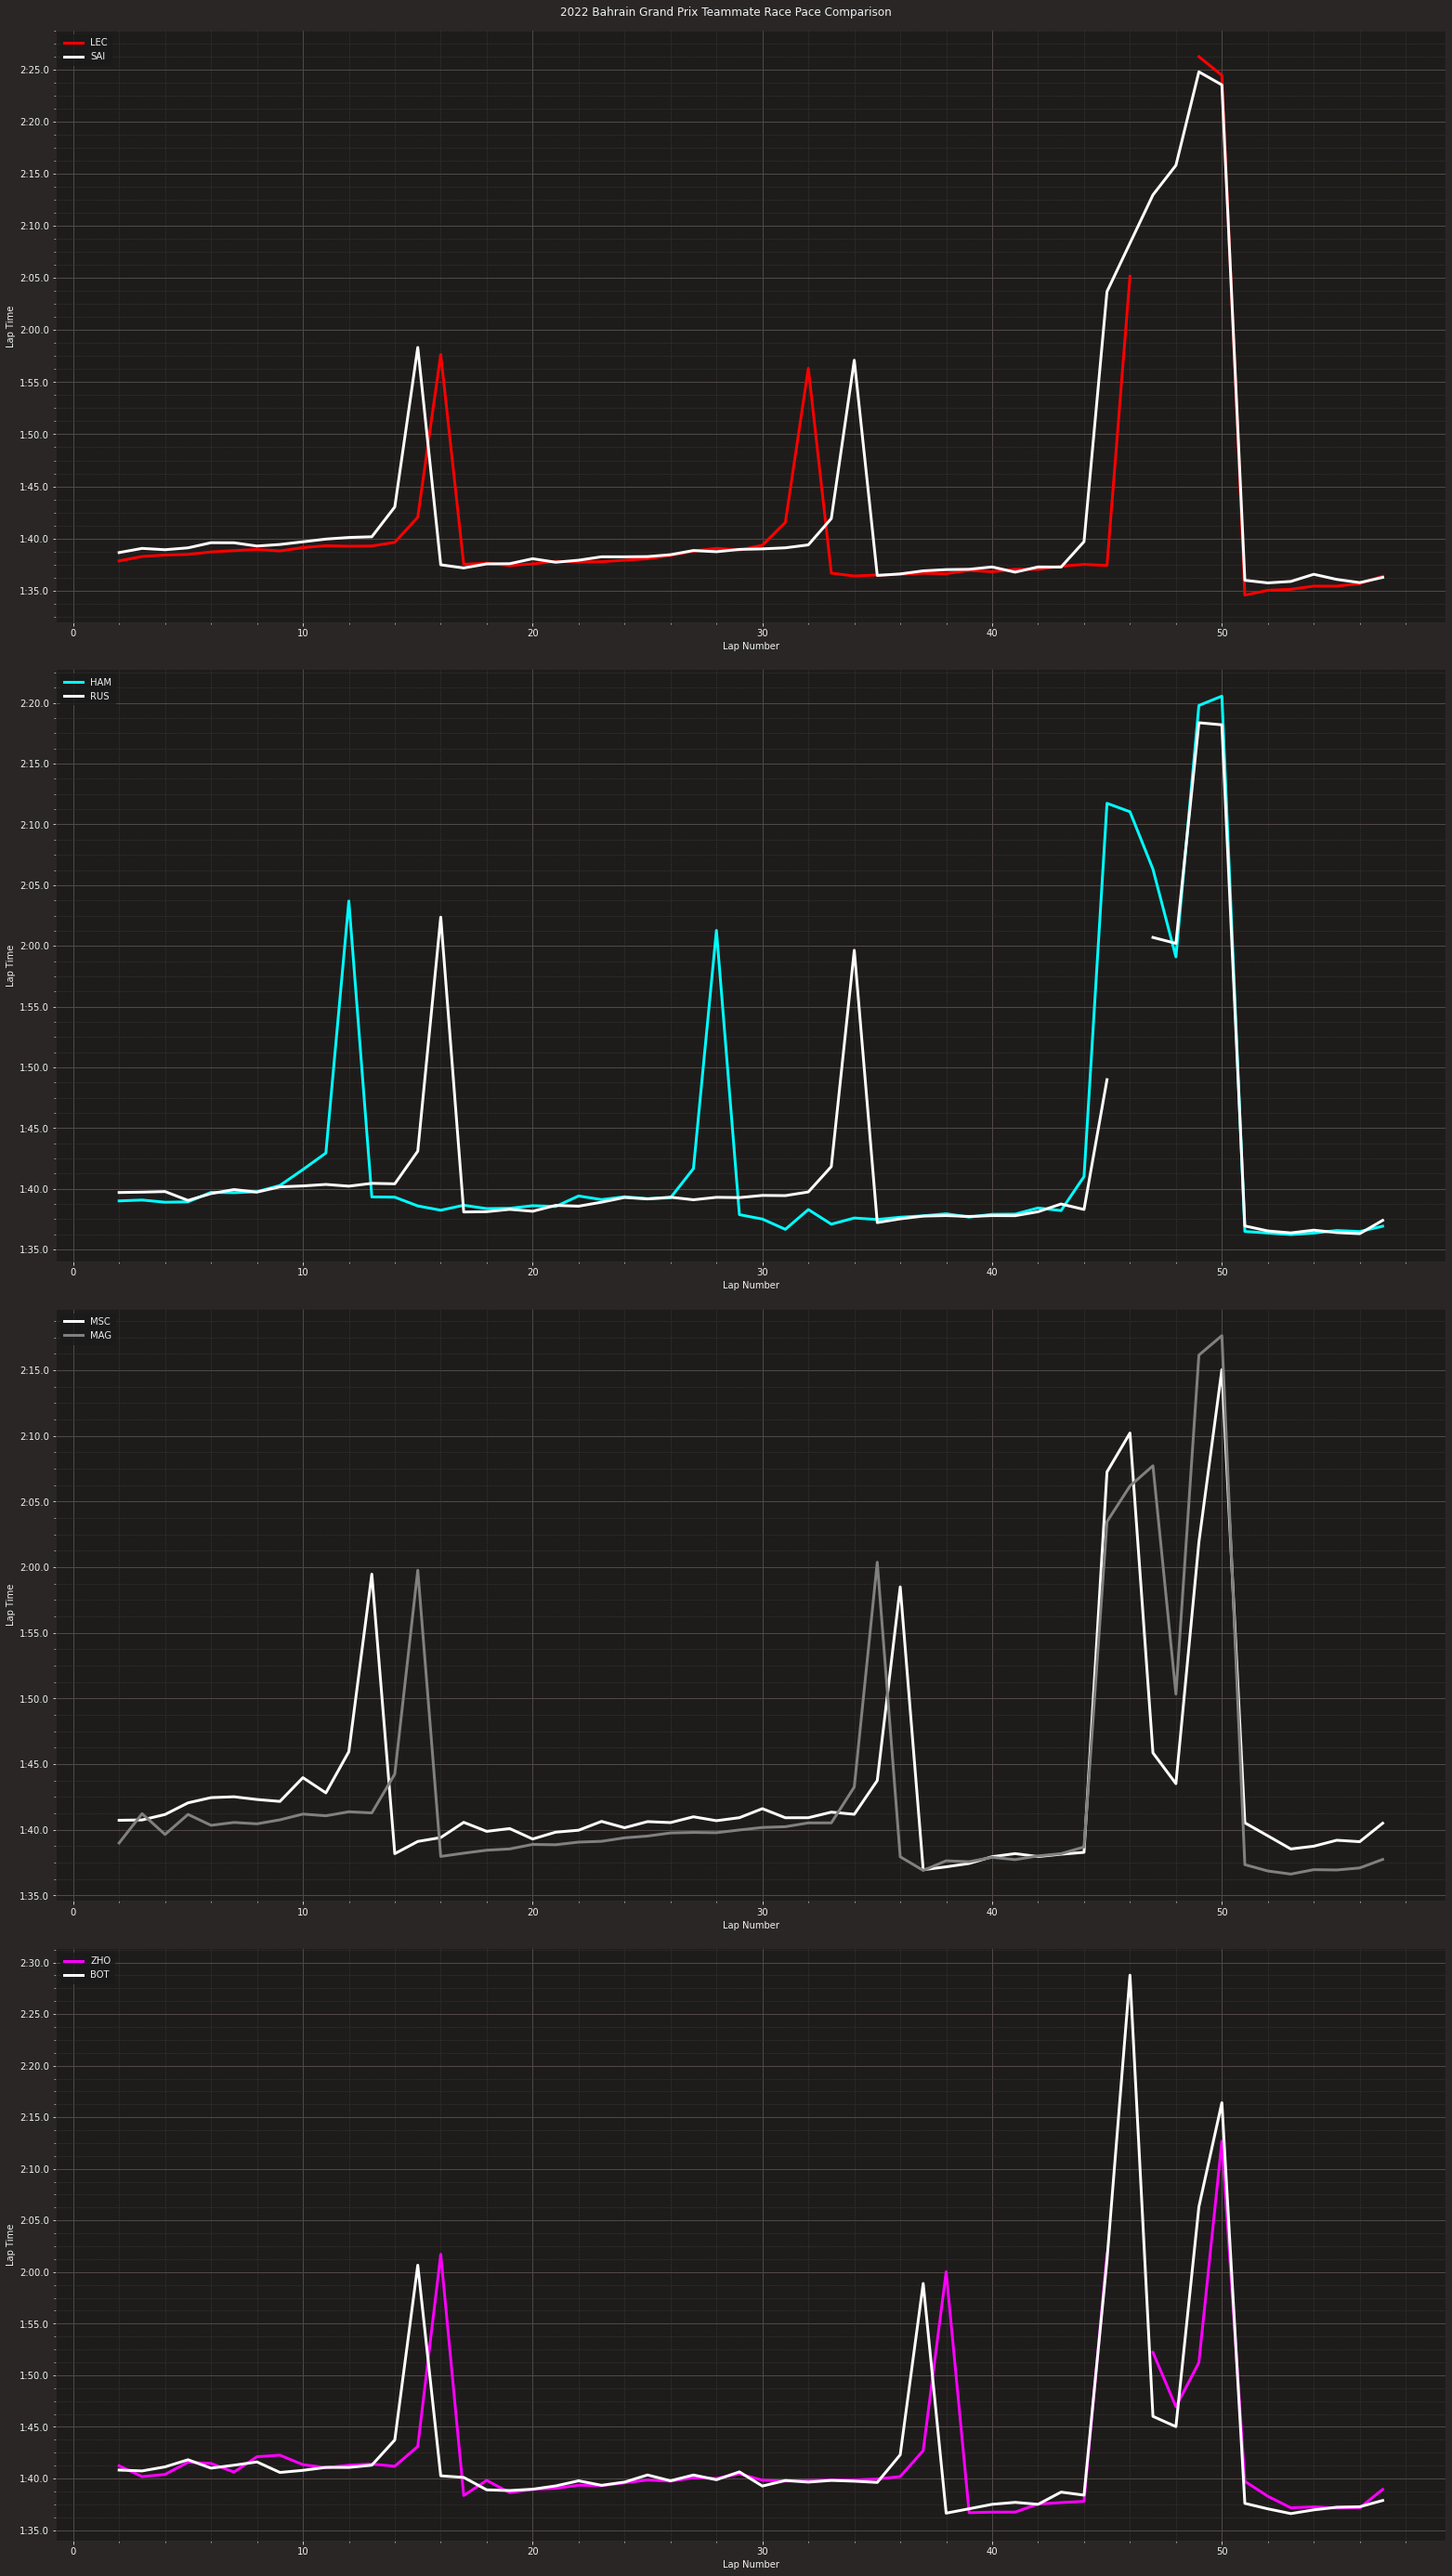

In [36]:
lecl=lapsr.pick_driver('LEC')
sain=lapsr.pick_driver('SAI')

hami=lapsr.pick_driver('HAM')
russ=lapsr.pick_driver('RUS')

magn=lapsr.pick_driver('MAG')
schu=lapsr.pick_driver('MSC')

bott=lapsr.pick_driver('BOT')
zhou=lapsr.pick_driver('ZHO')

fig, ax = plt.subplots(4, constrained_layout=True)
plt.gcf().set_size_inches(21.6,38.4)
ax[0].plot(lecl['LapNumber'], lecl['LapTime'], label='LEC', color='red',linewidth=3)
ax[0].plot(sain['LapNumber'], sain['LapTime'], label='SAI', color='white',linewidth=3)
ax[0].set_xlabel("Lap Number")
ax[0].set_ylabel("Lap Time")
ax[0].legend(loc="upper left")

ax[1].plot(hami['LapNumber'], hami['LapTime'], label='HAM',color='cyan',linewidth=3)
ax[1].plot(russ['LapNumber'], russ['LapTime'], label='RUS',color='white',linewidth=3)
ax[1].set_xlabel("Lap Number")
ax[1].set_ylabel("Lap Time")
ax[1].legend(loc="upper left")


ax[2].plot(schu['LapNumber'], schu['LapTime'], label='MSC',color='white',linewidth=3)
ax[2].plot(magn['LapNumber'], magn['LapTime'], label='MAG',color='grey',linewidth=3)
ax[2].set_xlabel("Lap Number")
ax[2].set_ylabel("Lap Time")
ax[2].legend(loc="upper left")


ax[3].plot(zhou['LapNumber'], zhou['LapTime'], label='ZHO',color='magenta',linewidth=3)
ax[3].plot(bott['LapNumber'], bott['LapTime'], label='BOT',color='white',linewidth=3)
ax[3].set_xlabel("Lap Number")
ax[3].set_ylabel("Lap Time")
ax[3].legend(loc="upper left")

plt.suptitle(f"2022 Bahrain Grand Prix Teammate Race Pace Comparison")
plt.savefig(f"2022 Bahrain Grand Prix Teammate Race Pace Comparison.jpeg",dpi=100)
plt.show()

### Race Finishing Time Difference Between Teammates

In [37]:
#Getting total time on track of the drivers in seconds
lapsr['TimeSeconds']=lapsr['Time'].dt.total_seconds()
lecl=lapsr.pick_driver('LEC')
lecl=lecl.loc[lecl['TimeSeconds'] == max(lecl['TimeSeconds'].dropna())]

sain=lapsr.pick_driver('SAI')
sain=sain.loc[sain['TimeSeconds'] == max(sain['TimeSeconds'].dropna())]

merge1=pd.merge(lecl,sain,how='outer')
fl1 = Laps(merge1).sort_values(by='TimeSeconds').reset_index(drop=True)
fl1.dropna(axis=1)

hami=lapsr.pick_driver('HAM')
hami=hami.loc[hami['TimeSeconds'] == max(hami['TimeSeconds'].dropna())]

russ=lapsr.pick_driver('RUS')
russ=russ.loc[russ['TimeSeconds'] == max(russ['TimeSeconds'].dropna())]

merge2=pd.merge(hami,russ,how='outer')
fl2=Laps(merge2).sort_values(by='TimeSeconds').reset_index(drop=True)
fl2.dropna(axis=1)

schu=lapsr.pick_driver('MSC')
schu=schu.loc[schu['TimeSeconds'] == max(schu['TimeSeconds'].dropna())]

magn=lapsr.pick_driver('MAG')
magn=magn.loc[magn['TimeSeconds'] == max(magn['TimeSeconds'].dropna())]

merge3=pd.merge(schu,magn,how='outer')
fl3=Laps(merge3).sort_values(by='TimeSeconds').reset_index(drop=True)
fl3.dropna(axis=1)


,Time,DriverNumber,LapTime,LapNumber,Stint,Sector1Time,Sector2Time,Sector3Time,Sector1SessionTime,Sector2SessionTime,...,Compound,TyreLife,FreshTyre,LapStartTime,Team,Driver,TrackStatus,IsAccurate,LapStartDate,TimeSeconds
0,0 days 02:40:23.508000,20,0 days 00:01:37.741000,57,4,0 days 00:00:31.338000,0 days 00:00:42.474000,0 days 00:00:23.929000,0 days 02:39:17.105000,0 days 02:39:59.579000,...,SOFT,14.0,False,0 days 02:38:45.767000,Haas F1 Team,MAG,1,True,2022-03-20 16:39:45.784,9623.508
1,0 days 02:40:41.274000,47,0 days 00:01:40.498000,57,3,0 days 00:00:32.971000,0 days 00:00:43.115000,0 days 00:00:24.412000,0 days 02:39:33.747000,0 days 02:40:16.862000,...,SOFT,24.0,False,0 days 02:39:00.776000,Haas F1 Team,MSC,2,True,2022-03-20 16:40:00.793,9641.274


In [38]:
b1=fl1.loc[fl1['TimeSeconds']==min(fl1['TimeSeconds'])]
best1=b1.pick_fastest()
fl1['RaceTimeDiff']=fl1['TimeSeconds']-best1['TimeSeconds']
print(fl1[['Driver', 'TimeSeconds', 'RaceTimeDiff']])

b2=fl2.loc[fl2['TimeSeconds']==min(fl2['TimeSeconds'])]
best2=b2.pick_fastest()
fl2['RaceTimeDiff']=fl2['TimeSeconds']-best2['TimeSeconds']
print(fl2[['Driver', 'TimeSeconds', 'RaceTimeDiff']])

b3=fl3.loc[fl3['TimeSeconds']==min(fl3['TimeSeconds'])]
best3=b3.pick_fastest()
fl3['RaceTimeDiff']=fl3['TimeSeconds']-best3['TimeSeconds']
print(fl3[['Driver', 'TimeSeconds', 'RaceTimeDiff']])

  Driver  TimeSeconds  RaceTimeDiff
0    LEC     9608.746           NaN
1    SAI     9614.299           NaN
  Driver  TimeSeconds  RaceTimeDiff
0    HAM     9618.398           NaN
1    RUS     9619.956           NaN
  Driver  TimeSeconds  RaceTimeDiff
0    MAG     9623.508           NaN
1    MSC     9641.274           NaN


In [39]:
tcol1 = list()
for index, lap in fl1.iterlaps():
    color = ff1.plotting.team_color(lap['Team'])
    tcol1.append(color)

tcol2 = list()
for index, lap in fl2.iterlaps():
    color = ff1.plotting.team_color(lap['Team'])
    tcol2.append(color)
    
tcol3 = list()
for index, lap in fl3.iterlaps():
    color = ff1.plotting.team_color(lap['Team'])
    tcol3.append(color)

C:\Users\EDGAR\anaconda3\lib\site-packages\fastf1\core.py:931: FutureWarning: The property `Session.weekend` has been renamed to `Session.event`.
 The old property will be removed ina future version.
  warnings.warn("The property `Session.weekend` has been renamed to "
C:\Users\EDGAR\anaconda3\lib\site-packages\fastf1\events.py:650: FutureWarning: The `Weekend.name` property is deprecated and will beremoved in a future version.
Use `Event['EventName']` or `Event.EventName` instead.
  warnings.warn(


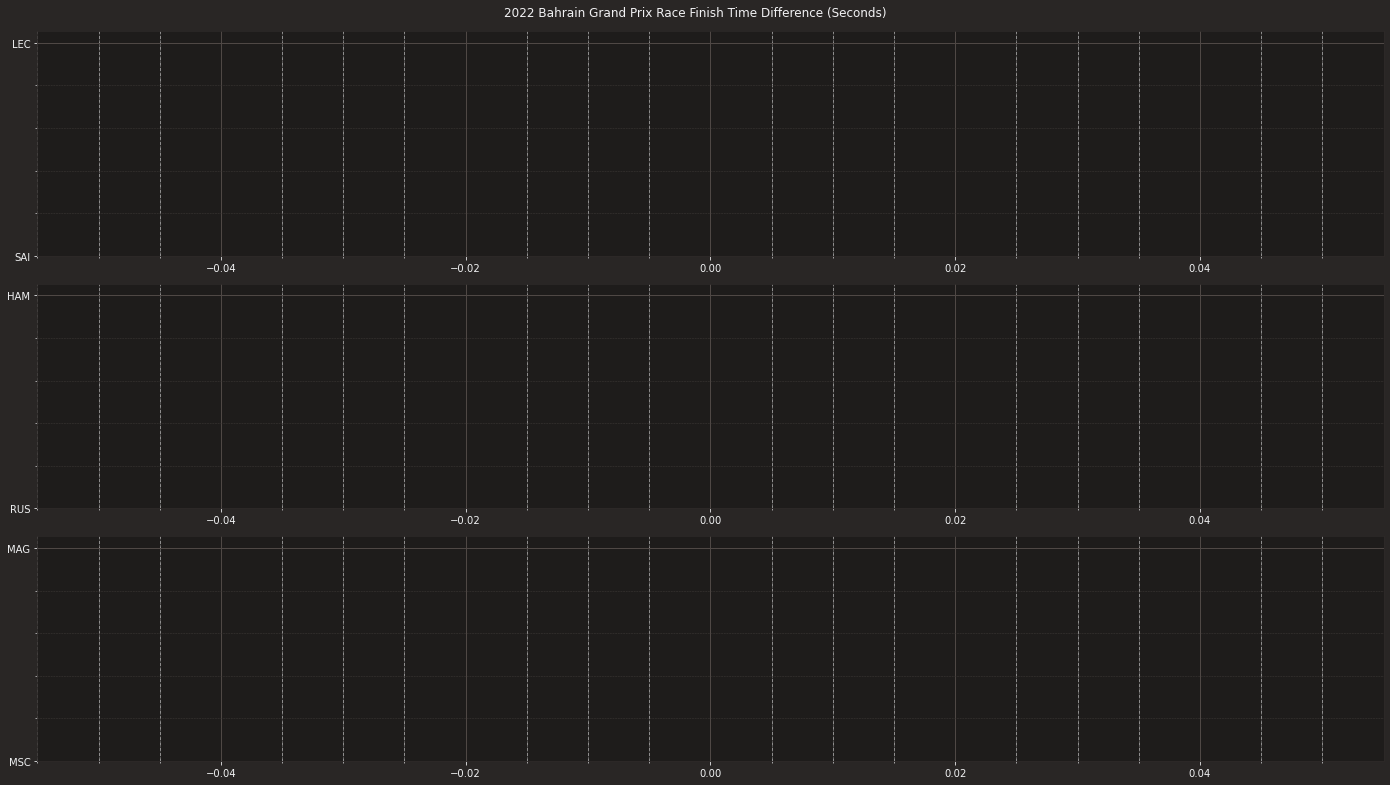

In [40]:
fig, ax = plt.subplots(3,constrained_layout=True)

plt.gcf().set_size_inches(19.2,10.8)

ax[0].barh(fl1.index, fl1['RaceTimeDiff'],color=tcol1, edgecolor='white')
ax[0].set_yticks(fl1.index)
ax[0].set_yticklabels(fl1['Driver'])
ax[0].invert_yaxis()
ax[0].set_axisbelow(True)
ax[0].xaxis.grid(True, which='minor', linestyle='-.', color='white', zorder=-1000)
# lapstr1 = strftimedelta(best1['TimeSeconds'], '%s.%ms')

ax[1].barh(fl2.index, fl2['RaceTimeDiff'],color=tcol2, edgecolor='white')
ax[1].set_yticks(fl2.index)
ax[1].set_yticklabels(fl2['Driver'])
ax[1].invert_yaxis()
ax[1].set_axisbelow(True)
ax[1].xaxis.grid(True, which='minor', linestyle='-.', color='white', zorder=-1000)
# lapstr2 = strftimedelta(best2['TimeSeconds'], '%s.%ms')

ax[2].barh(fl3.index, fl3['RaceTimeDiff'],color=tcol3, edgecolor='white')
ax[2].set_yticks(fl3.index)
ax[2].set_yticklabels(fl3['Driver'])
ax[2].invert_yaxis()
ax[2].set_axisbelow(True)
ax[2].xaxis.grid(True, which='minor', linestyle='-.', color='white', zorder=-1000)
# lapstr3 = strftimedelta(best3['TimeSeconds'], '%%s.%ms')
plt.suptitle(f"{quali.weekend.year} {quali.weekend.name} Race Finish Time Difference (Seconds)")


plt.savefig(f"{race.weekend.year} {race.weekend.name} Teammate RaceTime Difference.png", dpi=100)

plt.show()

### Tyre Strategy Analysis

In [41]:
driver_stints = lapsr[['Driver', 'Stint', 'Compound', 'LapNumber']].groupby(['Driver', 'Stint', 'Compound']).count().reset_index()
driver_stints = driver_stints.rename(columns={'LapNumber': 'StintLength'})
driver_stints = driver_stints.sort_values(by=['Stint'])
compound_colors = {'SOFT': 'Red','MEDIUM': 'Yellow','HARD': 'White'}
driver_stints = driver_stints[driver_stints.Compound != 'UNKNOWN']

TypeError: string indices must be integers

<Figure size 2764.8x1555.2 with 0 Axes>

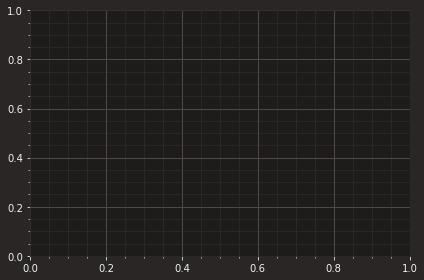

In [42]:
plt.gcf().set_size_inches(38.4,21.6)
# plt.rcParams["figure.autolayout"] = True
fig, ax = plt.subplots(tight_layout=True)
for driver in [driver['Driver']['code'] for driver in race.results]:
    stints = driver_stints.loc[driver_stints['Driver'] == driver]
    
    previous_stint_end = 0
    for _, stint in stints.iterrows():
        plt.barh([driver], stint['StintLength'], left=previous_stint_end,
            color=compound_colors[stint['Compound']], 
            edgecolor = "black")
        
        previous_stint_end = previous_stint_end + stint['StintLength']
plt.title(f'Tyre Strategy - {year} {circuit} ')
plt.xlabel('Lap')
plt.gca().invert_yaxis()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
plt.savefig(f"{year} {circuit} Tyre Strategies.jpeg", dpi=100)
plt.show()